<a href="https://colab.research.google.com/github/JulienGremillot/du_coup/blob/main/du_coup_tfjs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa tensorflowjs

     |████████████████████████████████| 77 kB 2.7 MB/s 
     |████████████████████████████████| 462 kB 17.9 MB/s 


In [2]:
import glob
import json
import os
import random

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import tensorflow as tf
import tensorflowjs as tfjs
import tqdm

print(tf.__version__)
print(tfjs.__version__)

2.8.0
3.14.0


In [3]:
# Download the TensorFlow.js Speech Commands model and the associated
# preprocesssing model.
!mkdir -p /tmp/tfjs-sc-model
!curl -o /tmp/tfjs-sc-model/metadata.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/metadata.json
!curl -o /tmp/tfjs-sc-model/model.json -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/model.json
!curl -o /tmp/tfjs-sc-model/group1-shard1of2 -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard1of2
!curl -o /tmp/tfjs-sc-model/group1-shard2of2 -fsSL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/v0.3/browser_fft/18w/group1-shard2of2
!curl -o /tmp/tfjs-sc-model/sc_preproc_model.tar.gz -fSsL https://storage.googleapis.com/tfjs-models/tfjs/speech-commands/conversion/sc_preproc_model.tar.gz
!cd /tmp/tfjs-sc-model/ && tar xzvf sc_preproc_model.tar.gz

sc_preproc_model/
sc_preproc_model/assets/
sc_preproc_model/variables/
sc_preproc_model/variables/variables.data-00000-of-00001
sc_preproc_model/variables/variables.index
sc_preproc_model/saved_model.pb


In [4]:
# Download Speech Commands v0.02 dataset. The dataset contains 30+ word and
# sound categories, but we will only use a subset of them

!mkdir -p /tmp/speech_commands_v0.02
!curl -o /tmp/speech_commands_v0.02/speech_commands_v0.02.tar.gz -fSsL http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!cd  /tmp/speech_commands_v0.02 && tar xzf speech_commands_v0.02.tar.gz

In [5]:
# Load the preprocessing model, which transforms audio waveform into 
# spectrograms (2D image-like representation of sound).
# This preprocessing model replicates WebAudio's AnalyzerNode.getFloatFrequencyData
# (https://developer.mozilla.org/en-US/docs/Web/API/AnalyserNode/getFloatFrequencyData).
# It performs short-time Fourier transform (STFT) using a length-2048 Blackman
# window. It opeartes on mono audio at the 44100-Hz sample rate.

preproc_model_path = '/tmp/tfjs-sc-model/sc_preproc_model'
preproc_model = tf.keras.models.load_model(preproc_model_path)
preproc_model.summary()
preproc_model.input_shape

Model: "audio_preproc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 audio_preprocessing_layer (  (None, None, 232, 1)     2048      
 AudioPreprocessingLayer)                                        
                                                                 
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


(None, 44032)

In [6]:
from google.colab import drive
import os
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [7]:
# Where the Speech Commands v0.02 dataset has been downloaded.
DATA_ROOT = "/tmp/speech_commands_v0.02"

In [8]:
import shutil
import pathlib
src_du_coup = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/du_coup')
dst_du_coup = pathlib.Path(os.path.join(DATA_ROOT, 'du_coup'))
if not dst_du_coup.exists():
  print('Copie le répertoire', src_du_coup, 'vers', dst_du_coup)
  shutil.copytree(src_du_coup, dst_du_coup)
else:
  print('Le répertoire', dst_du_coup, 'existe déjà.')

Copie le répertoire /content/gdrive/MyDrive/Colab Notebooks/du_coup vers /tmp/speech_commands_v0.02/du_coup


In [9]:
# Create some constants to be used later.

# Target sampling rate. It is required by the audio preprocessing model.
TARGET_SAMPLE_RATE = 44100
# The specific audio tensor length expected by the preprocessing model.
EXPECTED_WAVEFORM_LEN = preproc_model.input_shape[-1]


WORDS = ("_background_noise_snippets_", "du_coup")

In [10]:
# Unlike word examples, the noise samples in the Speech Commands v0.02 dataset
# are not divided into 1-second snippets. Instead, they are stored as longer
# recordings. Therefore we need to cut them up in to 1-second snippet .wav
# files.

noise_wav_paths = glob.glob(os.path.join(DATA_ROOT, "_background_noise_", "*.wav"))
snippets_dir = os.path.join(DATA_ROOT, "_background_noise_snippets_")
os.makedirs(snippets_dir, exist_ok=True)


def extract_snippets(wav_path, snippet_duration_sec=1.0):
  basename = os.path.basename(os.path.splitext(wav_path)[0])
  sample_rate, xs = wavfile.read(wav_path)
  assert xs.dtype == np.int16
  n_samples_per_snippet = int(snippet_duration_sec * sample_rate)
  i = 0
  while i + n_samples_per_snippet < len(xs):
    snippet_wav_path = os.path.join(snippets_dir, "%s_%.5d.wav" % (basename, i))
    snippet = xs[i : i + n_samples_per_snippet].astype(np.int16)
    wavfile.write(snippet_wav_path, sample_rate, snippet)
    i += n_samples_per_snippet

for noise_wav_path in noise_wav_paths:
  print("Extracting snippets from %s..." % noise_wav_path)
  extract_snippets(noise_wav_path, snippet_duration_sec=1.0)

Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/doing_the_dishes.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/pink_noise.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/exercise_bike.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/dude_miaowing.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/running_tap.wav...
Extracting snippets from /tmp/speech_commands_v0.02/_background_noise_/white_noise.wav...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  del sys.path[0]


In [11]:
def resample_wavs(dir_path, target_sample_rate=44100):
  """Resample the .wav files in an input directory to given sampling rate.
  
  The resampled waveforms are written to .wav files in the same directory with
  file names that ends in "_44100hz.wav".

  44100 Hz is the sample rate required by the preprocessing model. It is also
  the most widely supported sample rate among web browsers and mobile devices.
  For example, see:
  https://developer.mozilla.org/en-US/docs/Web/API/AudioContextOptions/sampleRate
  https://developer.android.com/ndk/guides/audio/sampling-audio

  Args:
    dir_path: Path to a directory that contains .wav files.
    target_sapmle_rate: Target sampling rate in Hz.
  """
  wav_paths = glob.glob(os.path.join(dir_path, "*.wav"))
  resampled_suffix = "_%shz.wav" % target_sample_rate
  for i, wav_path in tqdm.tqdm(enumerate(wav_paths)):
    if wav_path.endswith(resampled_suffix):
      continue
    sample_rate, xs = wavfile.read(wav_path)
    xs = xs.astype(np.float32)
    xs = librosa.resample(xs, sample_rate, TARGET_SAMPLE_RATE).astype(np.int16)
    resampled_path = os.path.splitext(wav_path)[0] + resampled_suffix
    wavfile.write(resampled_path, target_sample_rate, xs)


for word in WORDS:
  word_dir = os.path.join(DATA_ROOT, word)
  assert os.path.isdir(word_dir)
  resample_wavs(word_dir, target_sample_rate=TARGET_SAMPLE_RATE)

396it [00:19, 19.84it/s]
186it [00:05, 36.86it/s]


In [12]:
@tf.function
def read_wav(filepath):
  file_contents = tf.io.read_file(filepath)
  return tf.expand_dims(tf.squeeze(tf.audio.decode_wav(
      file_contents, 
      desired_channels=-1,
      desired_samples=TARGET_SAMPLE_RATE).audio, axis=-1), 0)


@tf.function
def filter_by_waveform_length(waveform, label):
  return tf.size(waveform) > EXPECTED_WAVEFORM_LEN


@tf.function
def crop_and_convert_to_spectrogram(waveform, label):
  cropped = tf.slice(waveform, begin=[0, 0], size=[1, EXPECTED_WAVEFORM_LEN])
  return tf.squeeze(preproc_model(cropped), axis=0), label


@tf.function
def spectrogram_elements_finite(spectrogram, label):
  return tf.math.reduce_all(tf.math.is_finite(spectrogram))


def get_dataset(input_wav_paths, labels):
  """Get a tf.data.Dataset given input .wav files and their labels.

  The returned dataset emits 2-tuples of `(spectrogram, label)`, wherein
  - `spectrogram` is a tensor of dtype tf.float32 and shape [43, 232, 1].
    It is z-normalized (i.e., have a mean of ~0.0 and variance of ~1.0).
  - `label` is a tensor of dtype tf.int32 and shape [] (scalar).
  
  Args:
    input_wav_paths: Input audio .wav file paths as a list of string.
    labels: integer labels (class indices) of the input .wav files. Must have
      the same lengh as `input_wav_paths`.

  Returns:
    A tf.data.Dataset object as described above.
  """
  ds = tf.data.Dataset.from_tensor_slices(input_wav_paths)
  # Read audio waveform from the .wav files.
  ds = ds.map(read_wav)
  ds = tf.data.Dataset.zip((ds, tf.data.Dataset.from_tensor_slices(labels)))
  # Keep only the waveforms longer than `EXPECTED_WAVEFORM_LEN`.
  ds = ds.filter(filter_by_waveform_length)
  # Crop the waveforms to `EXPECTED_WAVEFORM_LEN` and convert them to
  # spectrograms using the preprocessing layer.
  ds = ds.map(crop_and_convert_to_spectrogram)
  # Discard examples that contain infinite or NaN elements.
  ds = ds.filter(spectrogram_elements_finite)
  return ds

Found 396 examples for class _background_noise_snippets_
Found 186 examples for class du_coup


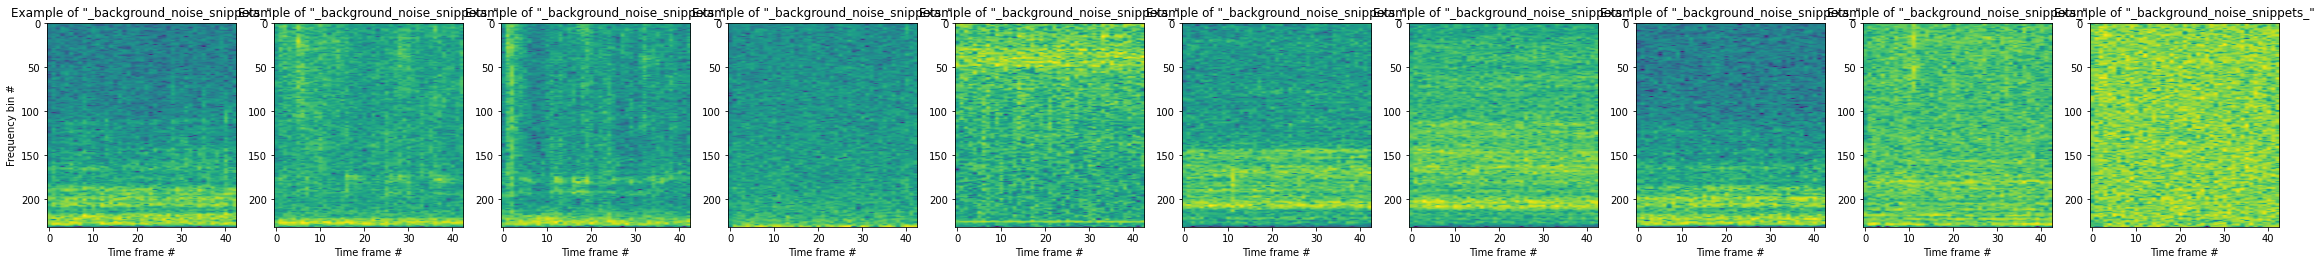

In [13]:
input_wav_paths_and_labels = []
for i, word in enumerate(WORDS):
  wav_paths = glob.glob(os.path.join(DATA_ROOT, word, "*_%shz.wav" % TARGET_SAMPLE_RATE))
  print("Found %d examples for class %s" % (len(wav_paths), word))
  labels = [i] * len(wav_paths)
  input_wav_paths_and_labels.extend(zip(wav_paths, labels))
random.shuffle(input_wav_paths_and_labels)
  
input_wav_paths, labels = ([t[0] for t in input_wav_paths_and_labels],
                           [t[1] for t in input_wav_paths_and_labels])
dataset = get_dataset(input_wav_paths, labels)

# Show some example spectrograms for inspection.
fig = plt.figure(figsize=(40, 100))
dataset_iter = iter(dataset)
num_spectrograms_to_show = 10
for i in range(num_spectrograms_to_show):
  ax = fig.add_subplot(1, num_spectrograms_to_show, i + 1)
  spectrogram, label = next(dataset_iter)
  spectrogram = spectrogram.numpy()
  label = label.numpy()
  plt.imshow(np.flipud(np.squeeze(spectrogram, -1).T), aspect=0.2)
  ax.set_title("Example of \"%s\"" % WORDS[label])
  ax.set_xlabel("Time frame #")
  if i == 0:
    ax.set_ylabel("Frequency bin #")

In [14]:
# The amount of data we have is relatively small. It fits into typical host RAM
# or GPU memory. For better training performance, we preload the data and
# put it into numpy arrays:
# - xs: The audio features (normalized spectrograms).
# - ys: The labels (class indices).
print(
    "Loading dataset and converting data to numpy arrays. "
    "This may take a few minutes...")
xs_and_ys = list(dataset)
xs = np.stack([item[0] for item in xs_and_ys])
ys = np.stack([item[1] for item in xs_and_ys])
print("Done.")

Loading dataset and converting data to numpy arrays. This may take a few minutes...
Done.


In [15]:
tfjs_model_json_path = '/tmp/tfjs-sc-model/model.json'

# Load the Speech Commands model. Weights are loaded along with the topology,
# since we train the model from scratch. Instead, we will perform transfer
# learning based on the model.
orig_model = tfjs.converters.load_keras_model(tfjs_model_json_path, load_weights=True)

# Remove the top Dense layer and add a new Dense layer of which the output
# size fits the number of sound classes we care about.
model = tf.keras.Sequential(name="TransferLearnedModel")
for layer in orig_model.layers[:-1]:
  model.add(layer)
model.add(tf.keras.layers.Dense(units=len(WORDS), activation="softmax"))

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "TransferLearnedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32

In [16]:
# Train the model.
model.fit(xs, ys, batch_size=256, validation_split=0.3, shuffle=True, epochs=50)

Epoch 1/50
2/2 [==============================] - 2s 425ms/step - loss: 0.7572 - acc: 0.6873 - val_loss: 0.0299 - val_acc: 0.9915
Epoch 2/50
2/2 [==============================] - 1s 196ms/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9915
Epoch 3/50
2/2 [==============================] - 1s 197ms/step - loss: 0.0250 - acc: 0.9964 - val_loss: 0.0296 - val_acc: 0.9915
Epoch 4/50
2/2 [==============================] - 1s 198ms/step - loss: 0.0165 - acc: 0.9964 - val_loss: 0.0308 - val_acc: 0.9915
Epoch 5/50
2/2 [==============================] - 1s 197ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9915
Epoch 6/50
2/2 [==============================] - 1s 194ms/step - loss: 0.0187 - acc: 0.9964 - val_loss: 0.0313 - val_acc: 0.9915
Epoch 7/50
2/2 [==============================] - 1s 200ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.9915
Epoch 8/50
2/2 [==============================] - 1s 195ms/step - loss: 0.0050 - acc: 1.00

In [17]:
WORDS[1:]

('du_coup',)

In [18]:
# Convert the model to TensorFlow.js Layers model format.

tfjs_model_dir = "/tmp/tfjs-model"
tfjs.converters.save_keras_model(model, tfjs_model_dir)

# Create the metadata.json file.
metadata = {"words": ["_background_noise_", 'du_coup'], "frameSize": model.input_shape[-2]}
with open(os.path.join(tfjs_model_dir, "metadata.json"), "w") as f:
  json.dump(metadata, f)

In [19]:
tfjs_model_dir

'/tmp/tfjs-model'

In [20]:
!ls -lh /tmp/tfjs-model

total 5.5M
-rw-r--r-- 1 root root 4.0M Mar 14 10:55 group1-shard1of2.bin
-rw-r--r-- 1 root root 1.5M Mar 14 10:55 group1-shard2of2.bin
-rw-r--r-- 1 root root   62 Mar 14 10:55 metadata.json
-rw-r--r-- 1 root root 6.3K Mar 14 10:55 model.json


In [21]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tfjs_model_dir + '/group1-shard1of2.bin')
  files.download(tfjs_model_dir + '/group1-shard2of2.bin')
  files.download(tfjs_model_dir + '/metadata.json')
  files.download(tfjs_model_dir + '/model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>